# Google trends data exploration

In [35]:
import pandas as pd
import numpy as np
import scipy as sp

from pytrends.request import TrendReq

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from graphviz import Digraph
from collections import deque
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings; warnings.simplefilter('ignore')

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)

### Setup a payload for 'Gas prices' in the US 

In [3]:
kw = "Gas prices"
kw_list = [kw]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

In [4]:
# Get the gasoline interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.head()

# TODO: List some major economic events in the U.S.
# Can even look at data by state - geo = 'US-WA' for example. can do a map visualization over time of state relative queries.

,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,5,False
2004-03-01,10,False
2004-04-01,11,False
2004-05-01,32,False


#### What do the numbers represent?
From google trends: "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."

### Check for null entries

In [5]:
has_null = any(interest_df[kw].isnull())
if has_null:
    print("Null entries found... removing null entries")
    interest_df = interest_df.dropna()
    has_null = any(interest_df['Gas prices'].isnull())
    
assert not has_null

### Check that there is consistent time granularity between rows

In [6]:
for i in range(interest_df.shape[0] - 1):
    entry_time_difference = interest_df.index[i + 1] - interest_df.index[i]
    x = list(entry_time_difference.components)
    assert sum(x) == max(x)

# A sample difference in time between rows.
print("Time granularity is approximately:", entry_time_difference)

Time granularity is approximately: 31 days 00:00:00


### Describe data

In [7]:
interest_df.describe()

,Gas prices
count,186.000000
mean,13.198925
std,11.035971
min,5.000000
25%,7.250000
50%,9.500000
75%,14.000000
max,100.000000


### Visualize the data

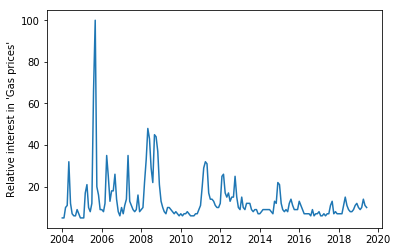

In [8]:
plt.plot(interest_df[kw])
plt.ylabel('Relative interest in \'{}\''.format(kw))
plt.show()

## Manual parameter selection ARIMA

We have adopted the ARIMA model since we are predicting a variable into the future using all the information we have on the past. Multiple linear regression will not work well for this approach for three reasons:
1. Our time series violates the assumption on homoscedacity, its mean and variance chances constantly across time.
2. It's also autocorrelated, which means that the residuals from a OLS fit would not be linear.
3. Multiple linear regression assumes no temporality which is a key component of forecasting. It also cannot predict into the future

ARIMA consists of 3 parameters, D, P, and Q which we will explore and manually set in the following sections.

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over [time](https://people.duke.edu/~rnau/411diff.htm).

From [stackexchange](https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary), "Stationarity is one way of modeling the dependence structure in the data. It turns out that a lot of nice results which hold for independent random variables (law of large numbers, central limit theorem to name a few) hold for stationary random variables".

In ARIMA, *differencing* is how timeseries are made stationary. There are different 'orders of differencing' that we can manually set in order to make the data stationary.

### Order of differencing (D)

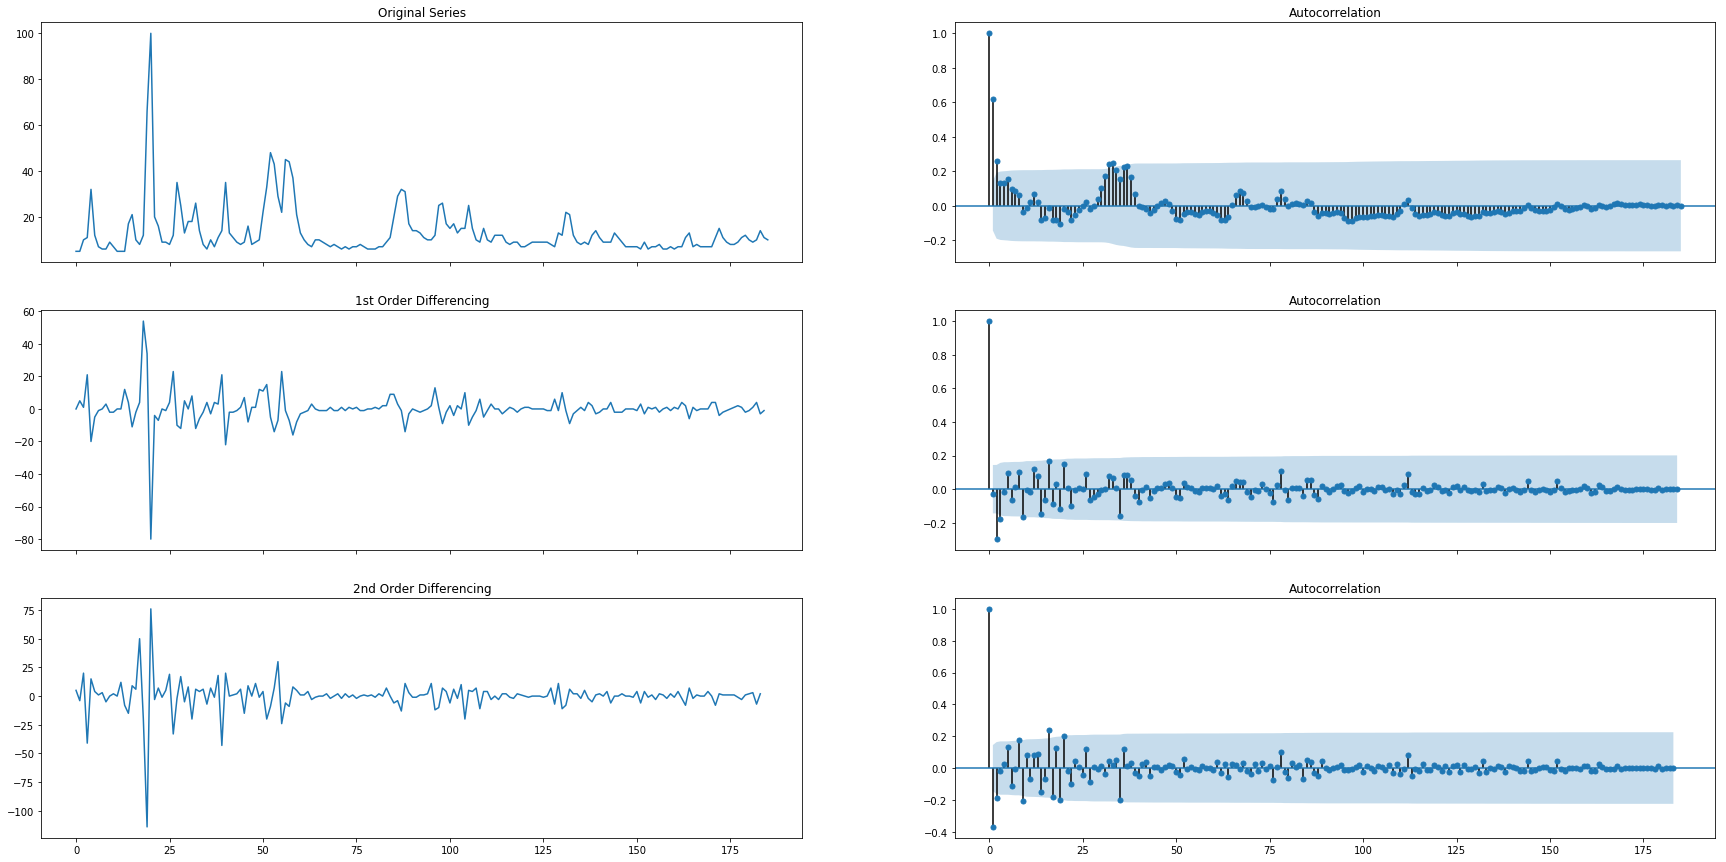

In [9]:
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(interest_df[kw].values); axes[0, 0].set_title('Original Series')
plot_acf(interest_df[kw].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(interest_df[kw].values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(interest_df[kw].values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(interest_df[kw].values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(interest_df[kw].values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

A 'lagged' value is [..........] <--------------------

The autocorrelation plots have the number of lagged values on the x-axis and the autocorrelation values on the y-axis. The blue region indicates a 95% confidence interval.

From [machinelearningmastery](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/), correlation values outside of the 95% confidence interval shown are very likely a correlation and not a statistical fluke.

For our model, we need to pick the number of lagged points to use. Any value that is outside of the 95% confidence interval therefore is a good candidate.

#### Augmented Dickey–Fuller (AD fuller) test

The ad-fuller test is a test of stationarity for timeseries data. The test provides a p-value and if the null-hypothesis is rejected, then the data is stationary (which is what we would like).

This is a similar test to the differencing that is shown above.

In [10]:
adf_dif0 = adfuller(interest_df[kw].values)
print('ADF Statistic, D = 0: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(interest_df[kw], axis = 0))
print('ADF Statistic, D = 1: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(interest_df[kw], axis = 0),axis = 0))
print('ADF Statistic, D = 2: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

ADF Statistic, D = 0: -5.706647 p-value: 0.000001
ADF Statistic, D = 1: -6.867317 p-value: 0.000000
ADF Statistic, D = 2: -7.479763 p-value: 0.000000


### Number of lags in the AR model (P)

Partial Autocorrelation (PACF) shows how much power adding additional lagged values has on autocorrelation. We don't want the lagged value to be too high, so PACF shows diminishing returns of adding more lagged values.

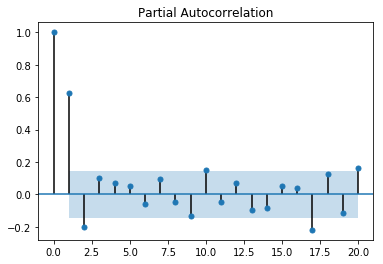

In [11]:
plot_pacf(interest_df[kw].values, lags = 20);

We plot ACF again to compare to the PACF above.

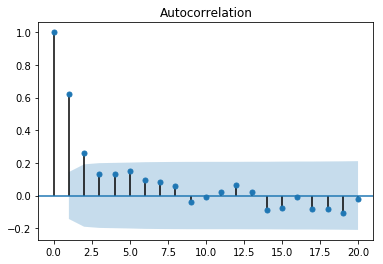

In [12]:
plot_acf(interest_df[kw], lags = 20);

We see that [.....] is the best lagged value to use here. <-----------------------------

## Model Fitting

In [19]:
order = np.array([3,1,1])
model = ARIMA(interest_df[kw], order=order)
model_fit = model.fit()
print(model_fit.summary())

/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.Gas prices   No. Observations:                  185
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -657.234
Method:                       css-mle   S.D. of innovations              8.351
Date:                Sun, 09 Jun 2019   AIC                           1326.468
Time:                        10:01:29   BIC                           1345.790
Sample:                    02-01-2004   HQIC                          1334.298
                         - 06-01-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0514      0.025     -2.062      0.041      -0.100      -0.003
ar.L1.D.Gas prices     0.7427      0.073     10.111      0.000       0.599       0.887
ar.L2.D.Gas prices  

In [175]:
def train_matrix(p_values, q_values):
    print("P values: ", p_values)
    print("Q values: ", q_values)
    models = []
    for q in q_values:
        models.append([])
        for p in p_values:
            print("(q, p): ({}, {})".format(q, p))
            order = np.array([p,1,q])
            model_fit = None
            try:
                model = ARIMA(interest_df[kw], order=order)
                model_fit = model.fit()
            except:
                pass
            models[-1].append(model_fit)
    return models

In [194]:
p_values = [i for i in range(1, 10)]
q_values = [1, 2, 3, 4, 5]
models = train_matrix(p_values, q_values)
aics = [[(model.aic if model is not None else np.nan) for model in q] for q in models]
print(aics)

P values:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Q values:  [1, 2, 3, 4, 5]
(q, p): (1, 1)
(q, p): (1, 2)
(q, p): (1, 3)
(q, p): (1, 4)
(q, p): (1, 5)
(q, p): (1, 6)
(q, p): (1, 7)
(q, p): (1, 8)
(q, p): (1, 9)
(q, p): (2, 1)
(q, p): (2, 2)
(q, p): (2, 3)
(q, p): (2, 4)
(q, p): (2, 5)
(q, p): (2, 6)
(q, p): (2, 7)
(q, p): (2, 8)
(q, p): (2, 9)
(q, p): (3, 1)
(q, p): (3, 2)
(q, p): (3, 3)
(q, p): (3, 4)
(q, p): (3, 5)
(q, p): (3, 6)
(q, p): (3, 7)
(q, p): (3, 8)
(q, p): (3, 9)
(q, p): (4, 1)
(q, p): (4, 2)
(q, p): (4, 3)
(q, p): (4, 4)
(q, p): (4, 5)
(q, p): (4, 6)
(q, p): (4, 7)
(q, p): (4, 8)
(q, p): (4, 9)
(q, p): (5, 1)
(q, p): (5, 2)
(q, p): (5, 3)
(q, p): (5, 4)
(q, p): (5, 5)
(q, p): (5, 6)
(q, p): (5, 7)
(q, p): (5, 8)
(q, p): (5, 9)
[[1332.4056608030917, 1325.5947882085284, 1326.4675506733597, 1327.9160471207642, 1329.7274924477965, 1330.8637456211263, 1331.8732873208742, 1336.274073855811, 1339.2111509896758], [1324.947737722075, 1326.8165715334749, 1329.5981196296968, nan, 1331.0917585

In [195]:
def plot_heatmap(fig, ax, matrix, p_values, q_values):
    cax = ax.matshow(matrix, cmap=plt.cm.Blues_r)
    fig.colorbar(cax, ax=ax)

    # Get smallest nonzero element
    mat_min = np.inf
    for row in matrix:
        for e in row:
            if e < mat_min and e != 0:
                mat_min = e

    # Draw numbers on heatmap
    for i in range(len(matrix[0])):
        for j in range(len(matrix)):
            c = matrix[j,i]
            c = np.round(c, 1)
            if c == 0:
                c = 'N/A'

            # Display the minimum perplexity, i.e, best value text in white.
            if matrix[j, i] == mat_min:
                ax.text(i, j, str(c), va='center', ha='center', color='white')
            else:
                ax.text(i, j, str(c), va='center', ha='center')

    # Set subplot titles and display
    ax.set_xticklabels([''] + p_values)
    ax.set_yticklabels([''] + q_values)

    ax.set(xlabel="P values")
    ax.set(ylabel="Q values") 
    #ax.set_title("Performance of various ARIMA models")

In [196]:
def get_rmse(models):
    rmses = []
    for d in models:
        rmses.append([])
        for p in d:
            rmse = np.nan
            if p is not None:
                pred = p.predict(dynamic=False)#(start=pd.to_datetime('2017-01-02'), dynamic=False)
                rmse = ((-1 * pred - interest_df[kw]) ** 2).mean() ** .5
            rmses[-1].append(rmse)
    return rmses

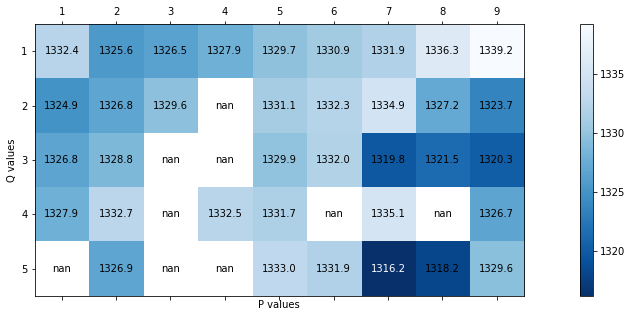

In [197]:
# Set up heatmap
fig, ax = plt.subplots(1, 1, figsize=(20,5))
#plt.subplots_adjust(wspace=0.5)#), hspace=1)
plot_heatmap(fig, ax, np.array(aics), p_values, q_values)
#plot_heatmap(fig, ax[1], np.array(get_rmse(models)), p_values, d_values)

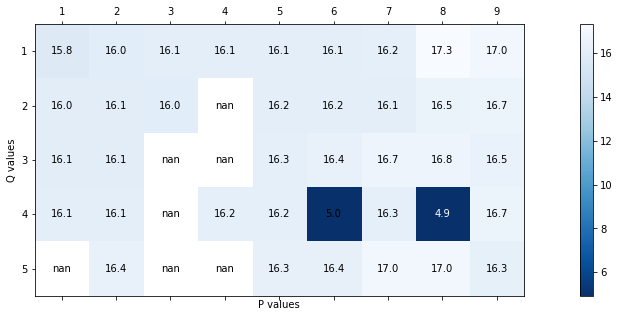

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
#plt.subplots_adjust(wspace=0.5)#), hspace=1)
plot_heatmap(fig, ax, np.array(get_rmse(models)), p_values, q_values)

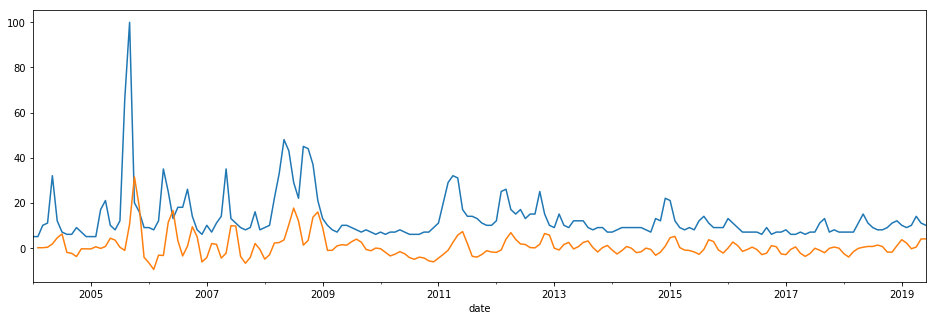

In [208]:
pred = models[4][8].predict(dynamic=False)
ax = interest_df[kw].plot(label='observed', figsize=(16,5))
(-1 * pred).plot(ax=ax, label='One-step ahead Forecast')
# ax.set_xlabel('Date')
# ax.set_ylabel('Gas Prices')
# plt.legend()
plt.show()
# models[0][0].plot_predict('2010', '', dynamic=False)
#plt.show()


                0
count  184.000000
mean     0.498045
std      8.579000
min    -46.923893
25%     -2.833841
50%     -1.250106
75%      1.608534
max     53.592158


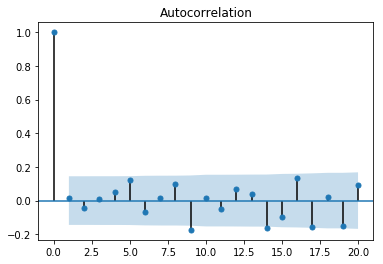

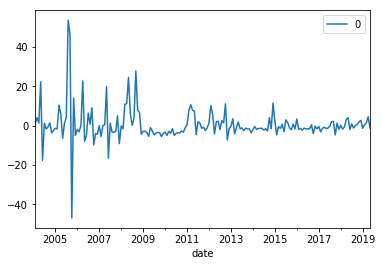

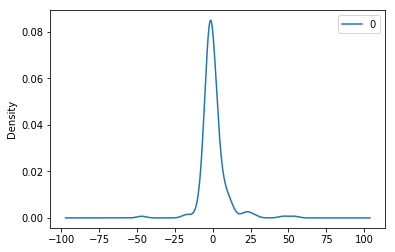

In [62]:
residuals = pd.DataFrame(model_fit.resid)
plot_acf(residuals, lags = 20);
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


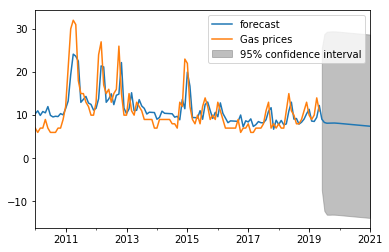

In [63]:
model_fit.plot_predict('2010', '2021', dynamic=False)
plt.show()

## Trend visualization for keywords

## Using related queries as feedback to get more results

In [19]:
def get_related_for_keyword(kw):
    kw_list = [kw]
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')
    interest_df = pytrends.interest_over_time()
    return pytrends.related_queries()

In [20]:
# Modify these to grow the size of the tree and to choose a different starting keyword
start_kw = 'Gas prices'
num_iters = 5
k = 3 # Top-k related keywords to find per word


graph_dict = {}
q = deque()
q.append(start_kw)

for i in range(num_iters):
    # get the next keyword
    kw = q.popleft()
    print("Finding related terms to {}...".format(kw))
    
    # Get related keywords for given keyword
    related = get_related_for_keyword(kw)

    # Get the top k related keywords
    top_k = list(related[kw]['top'][:k]['query'].values)
    
    # Add to graph data dict
    if kw not in graph_dict:
        graph_dict[kw] = []
    graph_dict[kw] = top_k
    
    q.extend(top_k)
print("Done")

Finding related terms to Gas prices...
Finding related terms to gas near me prices...
Finding related terms to gas price...
Finding related terms to natural gas...
Finding related terms to gas station prices...
Done


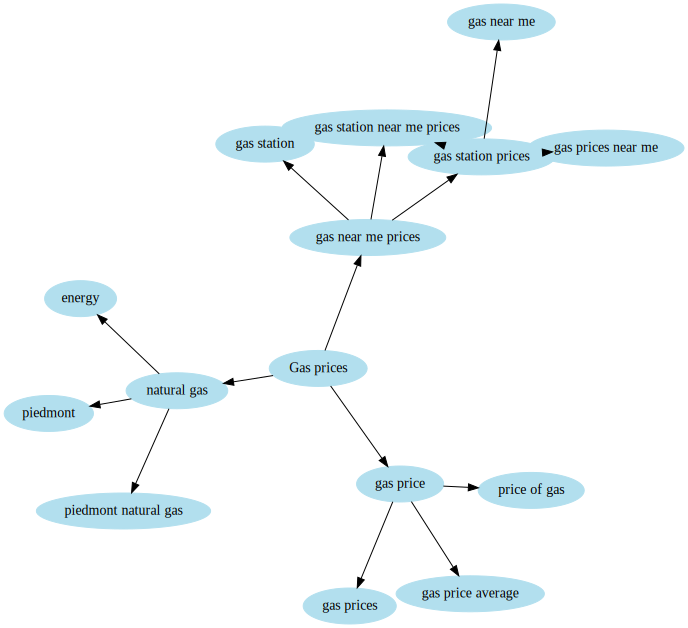

In [21]:
dot = Digraph(engine='neato')
dot.node_attr.update(color='lightblue2', style='filled')
dot.edge_attr.update(len='1.6')

for kw in graph_dict:
    dot.node(kw, kw)
    for child in graph_dict[kw]:
        dot.node(child, child)
        dot.edge(kw, child, length='1')
#dot.render('test', view=True, cleanup=True)
dot